<a href="https://colab.research.google.com/github/croco22/CapstoneProjectTDS/blob/main/notebooks/02_Dataset_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2: Dataset Evaluation
In this chapter, we conduct the evaluation using Q&A models. We assess and fine-tune various models from Hugging Face by applying different metrics from the literature to measure their performance. This includes evaluating their accuracy, precision, recall, and other relevant benchmarks to determine their effectiveness in answering questions. Additionally, we compare the performance of different models before and after fine-tuning to analyze the impact of our adjustments and improvements.

## Imports and Setup

In [1]:
%%capture
!pip install datasets
!pip install dateparser
!pip install fuzzywuzzy
!pip install word2number

import re
from datetime import datetime

import dateparser
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datasets import Dataset
from fuzzywuzzy import fuzz
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    jaccard_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from transformers import (
    AutoModelForQuestionAnswering,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    pipeline,
)
from word2number import w2n

In [2]:
url = 'https://raw.githubusercontent.com/croco22/CapstoneProjectTDS/refs/heads/main/qa_dataset.json'
data = pd.read_json(url)

data.head()

,type,question,options,intended_answer,context,timestamp
0,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Absolutely, you've got my consent for that dat...",2025-01-29 13:37:12.404
1,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Yes, you can absolutely process my data, that'...",2025-01-29 13:37:12.404
2,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Without any hesitation, I can confirm yes, tha...",2025-01-29 13:37:12.404
3,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"Okay then, for that question regarding data pr...",2025-01-29 13:37:12.404
4,SINGLE_SELECT,Data processing consent,"[Yes, No]",Yes,"That sounds perfectly fine to me, I wholeheart...",2025-01-29 13:37:12.404


## Auxilary Functions
*   Function to convert number words into actual numbers, e.g. "fifty-one" ➡ 51
*   Function to check if options appear explicitly in text
*   Function to calculate metrics
*   Function to visualize metrics


In [3]:
def convert_numbers_in_text(text):
    # Regular expression to find number words contained in questionnaires
    pattern = r'(two thousand|two hundred one|two hundred|fifty-one|thirty-one|twenty-one|sixteen|fifteen|eleven|thirty|twenty|fifty|forty|sixty|ten|five|six|one)'
    # Interesting finding: Regex only works if longer words are in order before shorter that contain similar parts, e.g. fifty-one has to be in front of fifty to work as intended

    def convert(match):
        word = match.group(0)
        try:
            # Convert the word to number
            return str(w2n.word_to_num(word))
        except ValueError:
            return word

    # Replace all number words in the text with their integer equivalents
    converted_text = re.sub(pattern, convert, text, flags=re.IGNORECASE)

    # Now convert ranges like 'twenty to thirty' into '20-30'
    converted_text = re.sub(r'(\d+)\s*(to|and)\s*(\d+)', r'\1-\3', converted_text)

    # Replace text
    # Todo: Dafür noch ne bessere Lösung finden, das ist eig nur n Beispiel und geht auch bei ähnlichen Sätzen nicht
    converted_text = converted_text.replace('more than 2000', 'larger than 2000')
    converted_text = converted_text.replace('More than 2000', 'Larger than 2000')

    return converted_text


def is_exact_or_phrase_match(option, text):
    # Escape the option to handle special characters
    escaped_option = re.escape(option.strip())

    # Pattern to match the option as a full word or part of a phrase
    pattern = rf'\b(?:\w+\s+)*{escaped_option}(?:\s+\w+)*\b'

    # Search for the pattern in the text (case-insensitive)
    return re.search(pattern, text, re.IGNORECASE) is not None


def calculate_metrics(y_true, y_pred):
    if not y_true:  # ensure y_true is not empty to avoid errors
        return {"Accuracy": 0, "Precision": 0, "Recall": 0, "F1 Score": 0, "Jaccard Score": 0}
    else:
        return {
            "Accuracy": accuracy_score(y_true, y_pred),
            "Precision": precision_score(y_true, y_pred, zero_division=0),
            "Recall": recall_score(y_true, y_pred, zero_division=0),
            "F1 Score": f1_score(y_true, y_pred, zero_division=0),
            "Jaccard Score": jaccard_score(y_true, y_pred, zero_division=0),
        }


def plot_metrics(metrics_per_type, overall_metrics):
    metric_names = ["Accuracy", "Precision", "Recall", "F1 Score", "Jaccard Score"]
    plt.figure(figsize=(8, 5))
    df_heatmap = pd.DataFrame(metrics_per_type).T
    sns.heatmap(df_heatmap, annot=True, cmap="coolwarm", linewidths=0.5, vmin=0, vmax=1)
    plt.title("Metrics per question type")
    plt.show()

## Generate QA Pipelines

**Models:**
*   deepset/roberta-base-squad2
*   distilbert-base-cased-distilled-squad
*   google-bert/bert-large-uncased-whole-word-masking-finetuned-squad

**Parameters:**
*   *topk (int, optional, defaults to 1)* – The number of answers to return (will be
chosen by order of likelihood).




In [4]:
qa_pipeline1 = pipeline("question-answering", model="deepset/roberta-base-squad2")
qa_pipeline2 = pipeline("question-answering", model='distilbert-base-cased-distilled-squad')
qa_pipeline3 = pipeline("question-answering", model='google-bert/bert-large-uncased-whole-word-masking-finetuned-squad')

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/473 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/261M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
# topk>1 to extract multiple answers from context
qa_pipeline_ms = pipeline("question-answering", model="deepset/roberta-base-squad2", top_k=10)

/usr/local/lib/python3.11/dist-packages/transformers/pipelines/question_answering.py:334: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


## Predict Function
Function to extract answers to given questions from a given context for different question types.

In [6]:
def predict_answers(df, qa_pipeline):
    metrics_per_type = dict()

    type_metrics = {t: {"y_true": [], "y_pred": []} for t in ["SINGLE_SELECT", "MULTI_SELECT", "DATE", "NUMBER"]}

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False

        if (row['type'] == "SINGLE_SELECT") or (row['type'] == "MULTI_SELECT"):
            if row['options']:
                converted_context = convert_numbers_in_text(row['context'])
            # Extract answers from context (topk > 1)
            results = qa_pipeline_ms(question=row['question'], context=converted_context)

            if isinstance(results, dict):
                # Convert to list if a single object is found
                results = [results]
            elif not isinstance(results, list):
                print(f"Warning: Unexpected output format from qa_pipeline for question: {row['question']}") # Bei Single Select nicht auch nur string möglich?
                continue

            # Check answer for similarity with given answer options
            for result in results:
                extracted_answer = result.get('answer', '')
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())
                    if similarity_score >= 40:  # Threshold for similarity
                        predictions.append((option, result.get('score', 0)))

        if row['type'] == "SINGLE_SELECT":
            # Select prediction with highest confidence
            if predictions:
                predicted_option, confidence = max(predictions, key=lambda x: x[1])
                is_correct = predicted_option == row['intended_answer']
            else:
                print(f"No predictions found for SINGLE_SELECT: {row['question']}")
                predicted_option = None

        if row['type'] == "MULTI_SELECT":
            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                print(f"No predictions found for MULTI_SELECT: {row['question']}")
                predicted_option = None

        if row['type'] == "DATE":
            try:
                # Base timestamp from dataframe column (Unix-Timestamp)
                base_timestamp = pd.Timestamp(row['timestamp'], unit='ms')

                # Extract time expression and convert it to an exact date
                extracted_time = qa_pipeline(question=row['question'], context=row['context'])['answer']
                parsed_date = dateparser.parse(
                    extracted_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )
                if not parsed_date:
                    raise ValueError(f"Unable to parse date from extracted time: {extracted_time}")

                predicted_option = parsed_date

                # Calculate intended date from intended answer
                intended_time = row['intended_answer']
                intended_date = dateparser.parse(
                    intended_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )

                # Compare predicted and intended date, one day buffer for more robust results
                is_correct = abs((predicted_option - intended_date).days) <= 1
                print(f"Extracted time: {extracted_time}, predicted date: {predicted_option.date()}, intended date: {intended_date.date()}")

            except Exception as e:
                print(f"[ERROR] DATE question processing failed: {e}")

        if row['type'] == "NUMBER":
            try:
                #Exctract phone number from context with QA pipeline (topk = 1)
                predicted_option = qa_pipeline(question=row['question'], context=row['context'])['answer']
                is_correct = predicted_option == row['intended_answer']
            except Exception as e:
                print(f"[ERROR] NUMBER question failed: {e}")

        # Ignore TEXT questions
        if row['type'] == "TEXT":
            continue

        # # Convert predictions and correct answers to binary form to calculate metrics
        # if row['type'] in ["SINGLE_SELECT", "MULTI_SELECT", "NUMBER"]:
        #     y_true.append(1 if row['intended_answer'] else 0)  # 1 = correct answer exists
        #     y_pred.append(1 if is_correct else 0)  # 1 = predicted correctly
        if row['type'] in type_metrics:
            type_metrics[row['type']]['y_true'].append(1 if row['intended_answer'] else 0)
            type_metrics[row['type']]['y_pred'].append(1 if is_correct else 0)

    # Calc metric for each type
    for q_type, data in type_metrics.items():
        metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"])

    # Calc overall metrics
    y_true_total = sum([data["y_true"] for data in type_metrics.values()], [])
    y_pred_total = sum([data["y_pred"] for data in type_metrics.values()], [])
    overall_metrics = calculate_metrics(y_true_total, y_pred_total)

    return metrics_per_type, overall_metrics

## Predict Function with Regex

**Problem:**
* QA models have difficulties with evaluating multi select questions
* Confidence for extracted answers is overall very low
* The contexts for multi-select questions seem to complicated for the model.
* Performance with Regex (is_exact_or_phrase_match) is much better (much higher accuracy and also faster)
* Therefore we implemented two functions:
    * One that doesn't use Regex to really challenge the QA models
    * A second one to achieve high overall accuracy
* Limitation of Regex: Can only be used, because we have given answer options

In [7]:
def predict_answers_regex(df, qa_pipeline):
    metrics_per_type = dict()

    type_metrics = {t: {"y_true": [], "y_pred": []} for t in ["SINGLE_SELECT", "MULTI_SELECT", "DATE", "NUMBER"]}

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False

        if (row['type'] == "SINGLE_SELECT") or (row['type'] == "MULTI_SELECT"):
            if row['options']:
                converted_context = convert_numbers_in_text(row['context'])
            # Extract answers from context (topk > 1)
            results = qa_pipeline_ms(question=row['question'], context=converted_context)

            if isinstance(results, dict):
                # Convert to list if a single object is found
                results = [results]
            elif not isinstance(results, list):
                print(f"Warning: Unexpected output format from qa_pipeline for question: {row['question']}")
                continue

            # Check answer for similarity with given answer options
            for result in results:
                extracted_answer = result.get('answer', '')
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())       # Hab den similarity_score hier auf 40 gesetzt - vorher 60 - test
                    if similarity_score >= 40:  # Threshold for similarity
                        predictions.append((option, result.get('score', 0)))

        if row['type'] == "SINGLE_SELECT":
            # Select prediction with highest confidence
            if predictions:
                predicted_option, confidence = max(predictions, key=lambda x: x[1])
                is_correct = predicted_option == row['intended_answer']
            else:
                print(f"No predictions found for SINGLE_SELECT: {row['question']}")
                predicted_option = None

        if row['type'] == "MULTI_SELECT":
            # Additional regex-check for multi-select questions
            for option in row['options']:
                # Check for exact match or part of a phrase
                exact_match = is_exact_or_phrase_match(option, converted_context)
                if exact_match:
                    predictions.append((option, 0.95))  # 95% confidence for exact match
            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                print(f"No predictions found for MULTI_SELECT: {row['question']}")
                predicted_option = None

            if predictions:
                # Select all answers that matched an option
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                print(f"No predictions found for MULTI_SELECT: {row['question']}")
                predicted_option = None

        if row['type'] == "DATE":
            try:
                # Base timestamp from dataframe column (Unix-Timestamp)
                base_timestamp = pd.Timestamp(row['timestamp'], unit='ms')

                # Extract time expression and convert it to an exact date
                extracted_time = qa_pipeline(question=row['question'], context=row['context'])['answer']
                parsed_date = dateparser.parse(
                    extracted_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )
                if not parsed_date:
                    raise ValueError(f"Unable to parse date from extracted time: {extracted_time}")

                predicted_option = parsed_date

                # Calculate intended date from intended answer
                intended_time = row['intended_answer']
                intended_date = dateparser.parse(
                    intended_time,
                    settings={'RELATIVE_BASE': base_timestamp.to_pydatetime(), 'PREFER_DATES_FROM': 'future'}
                )

                # Compare predicted and intended date, one day buffer for more robust results
                is_correct = abs((predicted_option - intended_date).days) <= 1
                print(f"Extracted time: {extracted_time}, predicted date: {predicted_option.date()}, intended date: {intended_date.date()}")

            except Exception as e:
                print(f"[ERROR] DATE question processing failed: {e}")

        if row['type'] == "NUMBER":
            try:
                #Exctract phone number from context with QA pipeline (topk = 1)
                predicted_option = qa_pipeline(question=row['question'], context=row['context'])['answer']
                is_correct = predicted_option == row['intended_answer']
            except Exception as e:
                print(f"[ERROR] NUMBER question failed: {e}")

        # Ignore TEXT questions
        if row['type'] == "TEXT":
            continue

        # # Convert predictions and correct answers to binary form to calculate metrics
        # if row['type'] in ["SINGLE_SELECT", "MULTI_SELECT", "NUMBER"]:
        #     y_true.append(1 if row['intended_answer'] else 0)  # 1 = correct answer exists
        #     y_pred.append(1 if is_correct else 0)  # 1 = predicted correctly
        if row['type'] in type_metrics:
            type_metrics[row['type']]['y_true'].append(1 if row['intended_answer'] else 0)
            type_metrics[row['type']]['y_pred'].append(1 if is_correct else 0)

    # Calc metric for each type
    for q_type, data in type_metrics.items():
        metrics_per_type[q_type] = calculate_metrics(data["y_true"], data["y_pred"])

    # Calc overall metrics
    y_true_total = sum([data["y_true"] for data in type_metrics.values()], [])
    y_pred_total = sum([data["y_pred"] for data in type_metrics.values()], [])
    overall_metrics = calculate_metrics(y_true_total, y_pred_total)

    return metrics_per_type, overall_metrics

## Evaluate Dataset with Pre-trained Models

### QA pipeline 1, without Regex

In [8]:
metrics, overall = predict_answers(data, qa_pipeline1)

No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Customer group
No predictions found for MULTI_SELECT: Products interested in
No predictions found for MULTI_SELECT: Products interested in
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for SINGLE_SELECT: Would you like to receive market


Overall metrics:
Accuracy: 0.5714
Precision: 1.0000
Recall: 0.5714
F1 Score: 0.7273
Jaccard Score: 0.5714


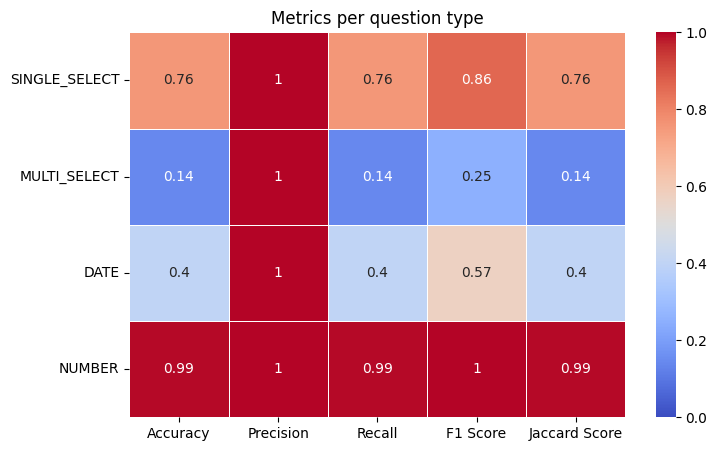

In [9]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)

### QA pipeline 2, without Regex

In [10]:
metrics, overall = predict_answers(data, qa_pipeline2)

No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Customer group
No predictions found for MULTI_SELECT: Products interested in
No predictions found for MULTI_SELECT: Products interested in
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for SINGLE_SELECT: Would you like to receive market


Overall metrics:
Accuracy: 0.5451
Precision: 1.0000
Recall: 0.5451
F1 Score: 0.7056
Jaccard Score: 0.5451


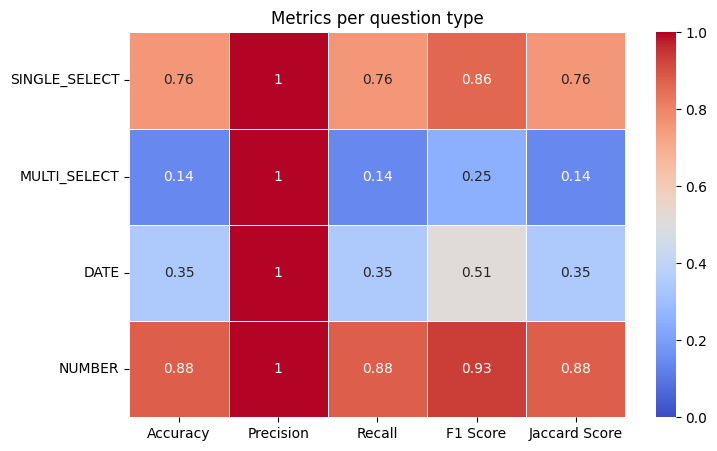

In [11]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)

### QA pipeline 3, without Regex

In [12]:
metrics, overall = predict_answers(data, qa_pipeline3)

No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Customer group
No predictions found for MULTI_SELECT: Products interested in
No predictions found for MULTI_SELECT: Products interested in
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for MULTI_SELECT: What kind of follow up is planned
No predictions found for SINGLE_SELECT: Would you like to receive market


Overall metrics:
Accuracy: 0.5466
Precision: 1.0000
Recall: 0.5466
F1 Score: 0.7069
Jaccard Score: 0.5466


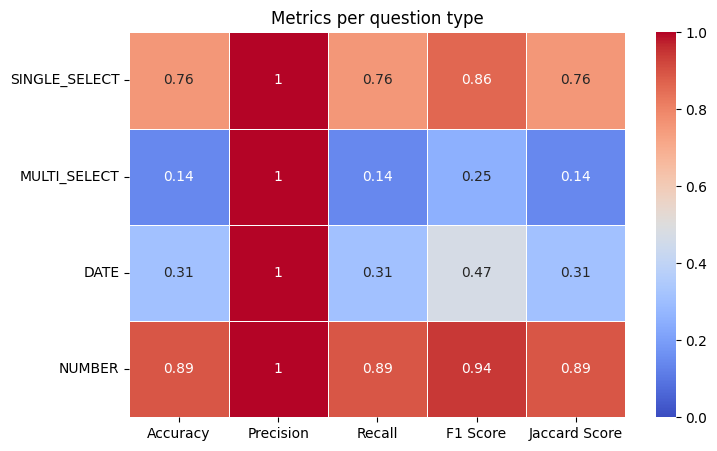

In [13]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)

### QA pipeline 1, WITH Regex

In [14]:
metrics, overall = predict_answers_regex(data, qa_pipeline1)

No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Data processing consent
No predictions found for SINGLE_SELECT: Customer group
No predictions found for SINGLE_SELECT: Would you like to receive marketing information from via e-mail?
No predictions found for SINGLE_SELECT: Would you like to receive marketing information from via e-mail?
No predictions found for SINGLE_SELECT: Would you like to receive marketing information from via e-mail?
No predictions found for SINGLE_SELECT: Would you like to receive marketing information from via e-mail?
Extracted time: tomorrow, predicted date: 2025-01-10, intended date: 2025-01-10
Extracted time: next week, predicted date: 2025-01-16, intend


Overall metrics:
Accuracy: 0.6361
Precision: 1.0000
Recall: 0.6361
F1 Score: 0.7776
Jaccard Score: 0.6361


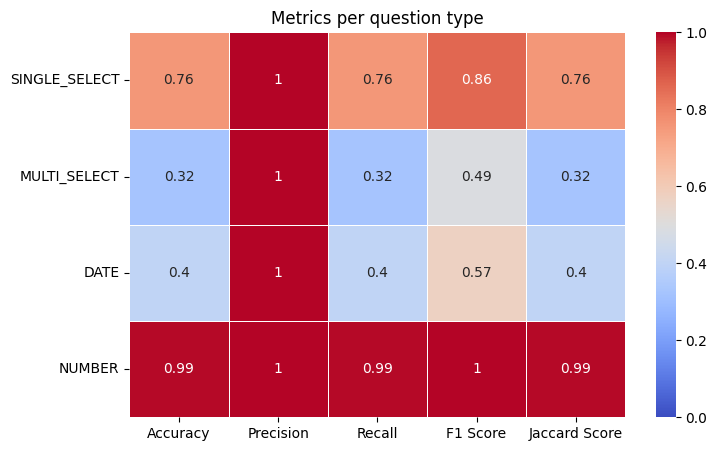

In [15]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)

**Results:**
The three QA pipelines yield very similar results. They all have an accuracy around 60%. The first pipeline is slightly better than the others. Through several tests, we found out that the bad accuracy resulst from the bad prediction of multi select questions. If we introduce an additional regex check for multi select questions, we achieve an accuracy of >80%.


### Tests for Multi-Select
As the qa models perform really bad on multi-select questions, we wanted to get some deeper insights into the evaluation.

In [16]:
def predict_MS_answers(df, qa_pipeline):
    correct_count = 0
    total_count = 0

    for _, row in df.iterrows():
        predictions = list()
        is_correct = False
        y_true = []  # list for correct values
        y_pred = []  # list for predicted values

        if (row['type'] == "MULTI_SELECT"):
            print(f"\nProcessing question: {row['question']} with type: {row['type']}")  # Welche Frage wird bearbeitet?
            print(f"\nProcessing context: {row['context']}")
            results = qa_pipeline(question=row['question'], context=row['context'])
            print(f"Pipeline results: {results}")

            if isinstance(results, dict):
                # In eine Liste umwandeln, falls ein einzelnes Ergebnis vorliegt
                results = [results]
            elif not isinstance(results, list):
                print(f"Warning: Unexpected output format from qa_pipeline for question: {row['question']}")
                continue

            # Verarbeite die Ergebnisse
            for result in results:
                extracted_answer = result.get('answer', '')
                print(f"Extracted answer: {extracted_answer}")  # Was wurde extrahiert?
                for option in row['options']:
                    similarity_score = fuzz.ratio(extracted_answer.lower(), option.lower())
                    print(f"Checking similarity: '{extracted_answer}' vs '{option}' → Score: {similarity_score}")
                    if similarity_score >= 40:  # Schwellenwert für Ähnlichkeit
                        predictions.append((option, result.get('score', 0)))

            if predictions:
                predicted_option = []
                for option, score in predictions:
                    if option not in predicted_option:
                        predicted_option.append(option)
                is_correct = set(predicted_option) == set(row['intended_answer'])
            else:
                print(f"No predictions found for MULTI_SELECT: {row['question']}")
                predicted_option = None

            y_true.append(1 if row['intended_answer'] else 0)  # 1 = korrekte Antwort existiert
            y_pred.append(1 if is_correct else 0)  # 1 = korrekt vorhergesagt

        # Ignore all other question types
        else:
          continue;

        if is_correct:
            correct_count += 1
        total_count += 1

    # Calculate metrics
    accuracy = correct_count / total_count if total_count > 0 else 0
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n[INFO] Accuracy: {accuracy:.4f}")
    print(f"[INFO] Precision: {precision:.4f}")
    print(f"[INFO] Recall: {recall:.4f}")
    print(f"[INFO] F1 Score: {f1:.4f}")

In [17]:
multi_select_data = data[data['type'] == 'MULTI_SELECT']
first_20_MS = multi_select_data.head(20)

predict_MS_answers(first_20_MS, qa_pipeline_ms)


Processing question: Products interested in with type: MULTI_SELECT

Processing context: Well, you know, I've been looking at a few things, like the MY-SYSTEM for general productivity, then of course there's Notion because everyone raves about it, I need a good backup system and JTS keeps popping up on my searches and that JS EcoLine sounds eco-friendly, oh, and lets not forget AKW100 for heavy duty storage.
Pipeline results: [{'score': 0.10768845677375793, 'start': 60, 'end': 94, 'answer': 'MY-SYSTEM for general productivity'}, {'score': 0.09010032564401627, 'start': 56, 'end': 94, 'answer': 'the MY-SYSTEM for general productivity'}, {'score': 0.07837676256895065, 'start': 60, 'end': 69, 'answer': 'MY-SYSTEM'}, {'score': 0.06557594239711761, 'start': 56, 'end': 69, 'answer': 'the MY-SYSTEM'}, {'score': 0.025532925501465797, 'start': 60, 'end': 125, 'answer': "MY-SYSTEM for general productivity, then of course there's Notion"}, {'score': 0.008520758710801601, 'start': 51, 'end': 94, '

## Fine-tune QA Model

*   We fine-tuned our best performing model (deepset/roberta-base-squad2) on our own data with the Huggingface Trainer API and the corresponding AutoTokeniizer
*   Problem: Intended answer serves as label
    *   QA model can only be trained with data, where the intended answer appears in exactly the same way in the context --> Some entries are not suitable for training
    *   We used multi select questions for training, but QA models are actually not meant to extract multiple answers
    *   Date and text questions are not suitable for training, because they don't have appropriate labels
    *   Lack of appropriate data leads to a bad model

In [18]:
# Prepare dataset in required format
def prepare_squad_data(df):
    squad_data = {"data": []}

    for idx, row in df.iterrows():
        question = row["question"]
        context = row["context"]
        intended_answer = row["intended_answer"]
        if (row['type'] == 'DATE') or (row['type'] == 'TEXT'):
          continue

        start_positions = []
        end_positions = []

        # Multi select questions
        if isinstance(intended_answer, list):
            for answer in intended_answer:
                answer = str(answer)  # Convert all entries to string
                start = context.find(answer)
                if start != -1:
                    start_positions.append(start)
                    end_positions.append(start + len(answer))
                else:
                    print(f"Warnung: Antwort '{answer}' nicht im Kontext enthalten. Überspringe Datensatz.")
                    continue
        # Single select questions
        elif isinstance(intended_answer, str):
            answer = intended_answer
            start = context.find(answer)
            if start != -1:
                start_positions.append(start)
                end_positions.append(start + len(answer))
            else:
                print(f"Warnung: Antwort '{answer}' nicht im Kontext enthalten. Überspringe Datensatz.")
                continue
        else:
            # Skip questions where intended answer is not a string or a list
            print(f"Warnung: 'intended_answer' hat ein ungültiges Format in Zeile {idx}. Überspringe Datensatz.")
            continue

        squad_data["data"].append({
    "paragraphs": [
        {
            "context": context,
            "qas": [
                {
                    "question": question,
                    "id": f"q_{idx}",
                    "answers": [
                        {"text": answer, "answer_start": start} for answer in intended_answer
                    ],
                    "is_impossible": False
                        }
                    ]
                }
            ]
        })

    return squad_data


def tokenize_squad_data(squad_data, tokenizer, max_length=512):
    """
    Tokenizes the prepared SQuAD-Dataset.
    """
    # Phone number Regex (for different international formats)
    phone_regex = re.compile(r"\+?\d{1,3}[-\s]?\(?\d{1,4}\)?[-\s]?\d{1,4}[-\s]?\d{1,9}")

    tokenized_examples = []

    for data in squad_data["data"]:
        for paragraph in data["paragraphs"]:
            # Preprocess context: mark phone numbers
            context = paragraph["context"]
            context_matches = phone_regex.findall(context)
            for match in context_matches:
                context = context.replace(match, f"[PHONE_TOKEN_{match}]")

            for qa in paragraph["qas"]:
                question = qa["question"]
                answers = qa["answers"]

                # Preprocess answers: mark phone numbers
                processed_answers = []
                for answer in answers:
                    answer_text = answer["text"]
                    if phone_regex.match(answer_text):
                        answer_text = f"[PHONE_TOKEN_{answer_text}]"
                    processed_answers.append({
                        "text": answer_text,
                        "answer_start": context.find(answer_text)  # New start position
                    })

                # Extract positions of answers
                start_positions = [answer["answer_start"] for answer in processed_answers]
                answer_texts = [answer["text"] for answer in processed_answers]

                # Tokenize questions and context
                tokenized_example = tokenizer(
                    question,
                    context,
                    max_length=max_length,
                    truncation="only_second",  # cut off context if too long
                    padding="max_length",
                    return_offsets_mapping=True
                )

                # Calculate token start positions for answers (case-insensitive)
                token_start_positions = []
                token_end_positions = []
                context_lower = context.lower()  # normalize context
                answer_texts_lower = [answer_text.lower() for answer_text in answer_texts]  # normalize answers

                for answer_text, answer_text_lower in zip(answer_texts, answer_texts_lower):
                    start_position = context_lower.find(answer_text_lower)  # Suche case-insensitive
                    if start_position != -1:
                        # Append actual start positions based on the original text
                        token_start_positions.append(start_position)
                        token_end_positions.append(start_position + len(answer_text))
                    else:
                        # Answer not found
                        print(f"Warning: Answer not found in context for question: {question}")
                        print(f"Intended answer: {answer_text}")
                        print(f"Context: {context}")

                # Save tokenized data
                tokenized_example["start_positions"] = token_start_positions[0] if token_start_positions else 0  # Handle empty list
                tokenized_example["end_positions"] = token_end_positions[0] if token_end_positions else 0  # Handle empty list
                tokenized_examples.append(tokenized_example)


    return tokenized_examples

In [19]:
# Split into training and test data (test data is not processed)
train_data, test_data = train_test_split(data, test_size=0.3, stratify=data["type"], random_state=42)

# Prepare training and evaluation data
squad_data = prepare_squad_data(train_data)

tokenizer = AutoTokenizer.from_pretrained("deepset/roberta-base-squad2")
tokenized_data = tokenize_squad_data(squad_data, tokenizer)

train_data, val_data = train_test_split(tokenized_data, test_size=0.3, random_state=42)

# Dataset Class for Huggingface
class SquadDataset:
    def __init__(self, data):
        self.data = Dataset.from_dict({k: [v] for k, v in data[0].items()})
        for item in data[1:]:
            self.data = self.data.add_item(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        return {
            "input_ids": item["input_ids"],
            "attention_mask": item["attention_mask"],
            "start_positions": item["start_positions"],
            "end_positions": item["end_positions"]
        }

# Create Huggingface Datasets
train_dataset = SquadDataset(train_data)
val_dataset = SquadDataset(val_data)
print(len(train_dataset))

Warnung: Antwort 'Risk of budget overruns' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Completing project deliverables' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Importance' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Urgency' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Physical Security' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Lead generation' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Client onboarding' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Sales forecasting' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Sales team communication' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Wholesaler, Distributor' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Medical' nicht im Kontext enthalten. Überspringe Datensatz.
Warnung: Antwort 'Insufficie

In [20]:
# Load model
model = AutoModelForQuestionAnswering.from_pretrained("deepset/roberta-base-squad2")

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    report_to="none"
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-20-8b90c16d767e>:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss
1,5.862800,6.067123


KeyboardInterrupt: 

In [ ]:
from google.colab import drive

# Check if the drive is already mounted
try:
    drive.mount('/content/drive', force_remount=True)  # Force remount if already mounted
except ValueError as e:
    # If drive is already mounted, skip and print message
    if "already mounted" in str(e):
        print("Drive already mounted at /content/drive")
    else:
        # If other error, raise it
        raise e

# Continue with saving the model
!cp -r ./results /content/drive/MyDrive

In [ ]:
# Load model and create pipeline
import os

results_path = '/content/drive/MyDrive/results'
folders = [os.path.join(results_path, folder) for folder in os.listdir(results_path) if os.path.isdir(os.path.join(results_path, folder))]
latest_folder = max(folders, key=os.path.getctime)

model_path = latest_folder
print(f"Der zuletzt erstellte Ordner ist: {model_path}")

model = AutoModelForQuestionAnswering.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

qa_pipeline_finetuned = pipeline("question-answering", model=model, tokenizer=tokenizer)

In [ ]:
metrics, overall = predict_answers(data, qa_pipeline_finetuned)

In [ ]:
print("Overall metrics:")
for key, value in overall.items():
    print(f"{key}: {value:.4f}")
print()

plot_metrics(metrics, overall)